[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pytextbook/pytextbook/blob/main/7.2.%20seoul-120-baseline-rnn.ipynb)

## RNN (Recurrent Neural Network) 으로 텍스트 분류하기

* API Document: https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN

## 라이브러리 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 미리보기 및 요약

In [5]:
df = pd.read_csv("/content/drive/MyDrive/claw/filter_민원분류.csv")
df.shape

(3081, 6)

In [6]:
# 제목과 내용을 합쳐서 문서라는 파생변수 생성
df["문서"] = df["UpdatedTitle"] + df["UpdatedContent"]
df.head()

,Name,Value.age,Value.sex,Value.dep_name,UpdatedContent,UpdatedTitle,문서
0,list,NONE,NONE,건설안전과,경기도 부천시 오정구 오정동 ***-*\n안녕하세요 \n여기는. 오정동 우체국 옆 ...,안녕하세요 여기는. 오정동 우체국 옆 상가 주차장 입,안녕하세요 여기는. 오정동 우체국 옆 상가 주차장 입경기도 부천시 오정구 오정동 *...
1,list,NONE,NONE,도시미관과,( https://www.safetyreport.go.kr/fileDown/singo/,쓰레기기를 낮애버려놓아 더니기불편해요* 안전신문고,쓰레기기를 낮애버려놓아 더니기불편해요* 안전신문고 ( https://www.saf...
2,list,30,1,건설안전과,부천 원미구 길주로***번길 ** ~ ** 사이 사거리 모서리쪽에 주차 못하게 차단...,주차 차단봉 설치,주차 차단봉 설치부천 원미구 길주로***번길 ** ~ ** 사이 사거리 모서리쪽에 ...
3,list,NONE,NONE,건설안전과,경기도 부천시 오정구 삼정동 ***-*\n*시 넘어서 켜지는데 **분을 넘게 깜박거...,*시 넘어서 켜지는데 **분을 넘게 깜박거리다가 켜져서,*시 넘어서 켜지는데 **분을 넘게 깜박거리다가 켜져서경기도 부천시 오정구 삼정동 ...
4,list,NONE,NONE,도시미관과,"경기도 부천시 원미구 춘의동 ***\n산울림 청소년 센터 입구에 있는 에어건 왼쪽,...",기타,기타경기도 부천시 원미구 춘의동 ***\n산울림 청소년 센터 입구에 있는 에어건 왼...


In [8]:
# value_counts()로 분류별 빈도수 확인
df["Value.dep_name"].value_counts()

,count
Value.dep_name,
도시미관과,807
장애인복지과,681
건설안전과,594
기후에너지과,471
차량등록과,267
대중교통과,261


In [ ]:
# 분류별 빈도수 값으로 불균형이 심해 전체 데이터로 예측을 하면 성능이 떨어질 수 있음
# 일부 상위 분류 데이터만을 추출해 사용
df = df[df["분류"].isin(["행정", "경제", "복지"])]
# df = df[df["분류"].isin(["행정", "경제"])]

In [9]:
# 정답(label) 값
label_name = "Value.dep_name"

In [10]:
# 독립변수(X, 문제)와 종속변수(y, 정답)
X = df["문서"]
y = df[label_name]

## label one-hot 형태로 만들기

In [11]:
# get_dummies 를 사용하여 label 값을 one-hot 형태로 생성
y_onehot = pd.get_dummies(y)

In [12]:
# train_test_split 으로 학습과 예측에 사용할 데이터를 나누기
# 정답값은 y_onehot 으로 지정
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2464,), (617,), (2464, 6), (617, 6))

In [13]:
y_train

,건설안전과,기후에너지과,대중교통과,도시미관과,장애인복지과,차량등록과
2017,False,False,True,False,False,False
1188,False,False,False,False,False,True
2394,False,False,False,False,False,True
2080,False,False,False,False,True,False
676,False,False,False,True,False,False
...,...,...,...,...,...,...
350,False,False,False,True,False,False
2820,False,True,False,False,False,False
692,True,False,False,False,False,False
923,True,False,False,False,False,False


In [14]:
display(y_train.mean())
display(y_test.mean())

,0
건설안전과,0.192776
기후에너지과,0.153003
대중교통과,0.084821
도시미관과,0.261769
장애인복지과,0.221185
차량등록과,0.086445


,0
건설안전과,0.192869
기후에너지과,0.152350
대중교통과,0.084279
도시미관과,0.262561
장애인복지과,0.220421
차량등록과,0.087520


## 벡터화
### 토큰화

1. 이 클래스를 사용하면 각 텍스트를 일련의 정수(각 정수는 사전에 있는 토큰의 인덱스임) 또는 단어 수에 따라 각 토큰의 계수가 이진일 수 있는 벡터로 변환하여 텍스트 말뭉치를 벡터화할 수 있습니다.(tf-idf 기반)

2. 매개변수
- num_words
: 단어 빈도에 따라 유지할 최대 단어 수입니다. 가장 일반적인 단어 만 유지됩니다.
-filters
: 각 요소가 텍스트에서 필터링될 문자인 문자열입니다. 기본값은 문자를 제외한 모든 구두점과 탭 및 줄 바꿈 '입니다.
- lower
: 부울. 텍스트를 소문자로 변환할지 여부입니다.
- split
: str. 단어 분할을 위한 구분 기호입니다.
- char_level
: True이면 모든 문자가 토큰으로 처리됩니다.
- oov_token
: 주어진 경우, 그것은 word_index에 추가되고 text_to_sequence 호출 중에 어휘 밖의 단어를 대체하는 데 사용됩니다.

3. 벡터화 과정
- Tokenizer 인스턴스를 생성
- fit_on_texts와 word_index를 사용하여 key value로 이루어진 딕셔너리를 생성
- texts_to_sequences를 이용하여 text 문장을 숫자로 이루어진 리스트로 변경
- 마지막으로 pad_sequences를 이용하여 리스트의 길이를 통일화


* API Document: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

### 시퀀스 만들기

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [16]:
# Tokenizer 는 데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서
# num_words 에 지정된 만큼만 숫자로 반환하고, 나머지는 0 으로 반환
# 단어 사전의 크기를 지정해 주기 위해 vocab_size를 지정
# vocab_size는 텍스트 데이터의 전체 단어 집합의 크기

vocab_size = 1000
oov_tok = "<oov>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token = oov_tok)
tokenizer

In [17]:
# Tokenizer 에 데이터 실제로 입력합니다.
# fit_on_texts와 word_index를 사용하여 key value로 이루어진 딕셔너리를 생성
tokenizer.fit_on_texts(X_train)

In [18]:
# tokenizer의 word_index 속성은 단어와 숫자의 키-값 쌍을 포함하는 딕셔너리를 반환
# 이때, 반환 시 자동으로 소문자로 변환되어 들어가며, 느낌표나 마침표 같은 구두점은 자동으로 제거
# 각 인덱스에 해당하는 단어가 무엇인지 확인

word_to_index = tokenizer.word_index
sorted(word_to_index)[:10]

["'",
 "'국가법령정보센터'에",
 "'네이버",
 "'담배꽁초",
 "'데몰리션",
 "'부천시",
 "'상동",
 "'서울원탑정형외과'라는",
 "'서울원탑정형외과'의",
 "'선수'"]

In [19]:
# 단어별 빈도수를 확인
list(tokenizer.word_counts.items())[:5]

[('버스전용차로', 52), ('위반', 119), ('차량번호', 164), ('무', 10), ('https', 212)]

In [20]:
# 단어별 빈도수를 확인
word_df = pd.DataFrame(tokenizer.word_counts.items(), columns = ['단어', '빈도수']).set_index("단어")
word_df.sort_values(by="빈도수", ascending=False).T

단어,부천시,신고입니다,불법주차,원미구,장애인,전용구역,경기도,안전신문고,친환경차,충전구역,...,리모델링공사에,수고해,주심에도,넣게되어,죄송하게,맨발걷기길과,산책길이,합쳐지는,곡선으로,도로같은
빈도수,2085,1642,1618,1263,1103,988,721,708,670,631,...,1,1,1,1,1,1,1,1,1,1


In [21]:
# texts_to_sequences를 이용하여 text 문장을 숫자로 이루어진 리스트로 변경
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

## 패딩(Padding)

* API Document: https://www.tensorflow.org/tutorials/keras/text_classification

In [22]:
# 독립변수를 전처리합니다.
# 문장의 길이가 제각각인 벡터의 크기를 패딩 작업을 통해 나머지 빈 공간을 0으로 채움
# max_length는 패딩의 기준이 됨
# padding_type='post' 는 패딩을 앞(기본값)이 아닌 뒤('post')에 채움
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 500
padding_type = "post"
# padding_type = "pre"

X_train_sp = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
X_test_sp = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)


print(X_train.shape)

(2464,)


## 모델 만들기

### simple RNN

* API Document: https://www.tensorflow.org/guide/keras/rnn
* API Document: https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNNCell

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, GRU, Bidirectional, LSTM, Dropout, BatchNormalization

In [24]:
# 하이퍼파라미터(모델링할 때 사용자가 직접 세팅해주는 값)을 설정
# vocab_size는 텍스트 데이터의 전체 단어 집합의 크기
# embedding_dim는 임베딩 할 벡터의 차원
# max_length는 패딩의 기준

embedding_dim = 64

In [25]:
# 클래스의 수는 분류될 예측값의 종류
# 정답값이 one-hot 형태로 인코딩 되어 있기 때문에 정답값의 컬럼의 수가 예측값의 종류가 됨
n_class = y_train.shape[1]
n_class

6

## Bidirectional RNN

In [26]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    BatchNormalization(),
    Bidirectional(LSTM(units=32)),
    Dropout(0.2),
    Dense(units=16, activation='relu'),
    Dense(units=n_class, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


* https://www.tensorflow.org/guide/keras/rnn#%EC%96%91%EB%B0%A9%ED%96%A5_rnn

### Bidirectional LSTM

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1600px-Long_Short-Term_Memory.svg.png" width="400">

* 출처 : https://ko.wikipedia.org/wiki/%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D
* API Document: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

### GRU

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Gated_Recurrent_Unit.svg/1600px-Gated_Recurrent_Unit.svg.png" width="400">

* 출처 : https://ko.wikipedia.org/wiki/%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D
* API Document: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

## 모델 컴파일

In [27]:
# 여러개 정답 중 하나 맞추는 문제이며, 정답값이 one-hot 형태이기 때문에
# 손실 함수는 categorical_crossentropy를 사용
model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 학습

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [30]:
# 모델 학습을 실행
history = model.fit(
    X_train_sp, y_train,
    epochs=100, batch_size=64, callbacks=early_stop, validation_split=0.2,
)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.3159 - loss: 1.6080 - val_accuracy: 0.3935 - val_loss: 1.7112
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6312 - loss: 0.9390 - val_accuracy: 0.6389 - val_loss: 1.6016
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.7118 - loss: 0.7914 - val_accuracy: 0.7505 - val_loss: 1.4741
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7919 - loss: 0.6459 - val_accuracy: 0.7120 - val_loss: 1.3408
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8511 - loss: 0.4869 - val_accuracy: 0.8235 - val_loss: 1.2030
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8746 - loss: 0.4316 - val_accuracy: 0.8032 - val_loss: 1.0239
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9126 - loss: 0.2792 - val_accuracy: 0.8235 - val_loss: 0.9228
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9215 - loss: 0.2677 - val_accuracy: 0.8073 - v

In [31]:
# 모델 학습의 결과값을 데이터 프레임으로 만들어 확인
df_hist = pd.DataFrame(history.history)

In [32]:
# 모델 학습 결과을 그래프로 시각화
df_hist

,accuracy,loss,val_accuracy,val_loss
0,0.459158,1.389965,0.393509,1.711225
1,0.661086,0.902306,0.638945,1.601552
2,0.744800,0.727458,0.750507,1.474130
3,0.799594,0.628779,0.711968,1.340811
4,0.875190,0.436467,0.823529,1.203047
5,0.894977,0.377494,0.803245,1.023913
6,0.914257,0.293514,0.823529,0.922771
7,0.928463,0.251365,0.807302,0.802118
8,0.933536,0.218797,0.872211,0.629382
9,0.951294,0.178089,0.797160,0.680673


<Axes: >

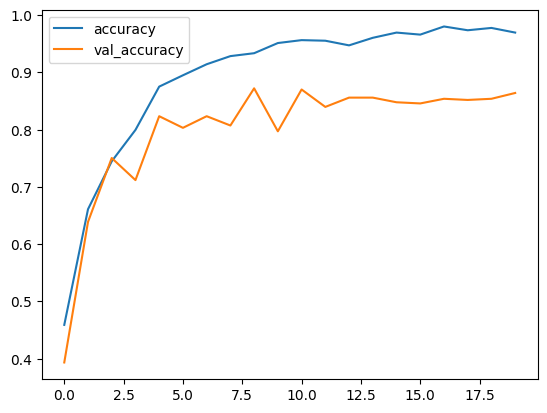

In [33]:
df_hist[["accuracy", "val_accuracy"]].plot()

<Axes: >

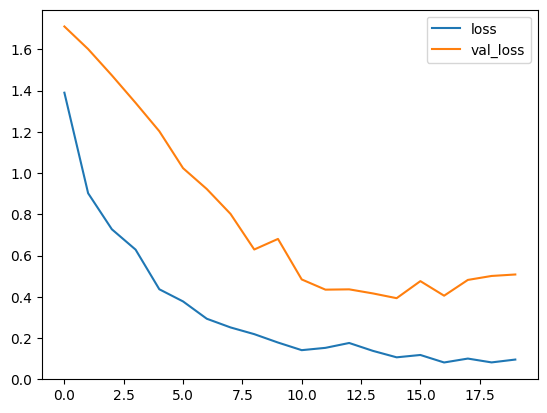

In [34]:
df_hist[["loss", "val_loss"]].plot()

## 예측

In [35]:
# predict() 메서드로 모델 예측
y_pred = model.predict(X_test_sp)
y_pred[:10]

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step


array([[4.8512025e-05, 7.9245074e-06, 7.0870396e-06, 1.1284404e-03,
        9.9832839e-01, 4.7959990e-04],
       [4.7871815e-03, 1.8545435e-04, 9.8315483e-01, 7.0409267e-03,
        4.1736104e-04, 4.4143009e-03],
       [9.6858925e-01, 8.3388505e-04, 6.8602798e-04, 2.6765740e-02,
        2.5424335e-04, 2.8707532e-03],
       [1.8488440e-01, 2.7416139e-03, 7.0469603e-02, 6.8414670e-01,
        3.8700746e-03, 5.3887539e-02],
       [8.9580631e-01, 1.1429428e-03, 6.1794156e-03, 9.0020455e-02,
        8.7582303e-04, 5.9751295e-03],
       [9.9340099e-01, 1.5044905e-04, 9.5755077e-04, 3.8856647e-03,
        5.4569540e-05, 1.5507744e-03],
       [4.4106371e-03, 1.0613968e-04, 9.8821145e-01, 4.5935595e-03,
        1.3316963e-04, 2.5451875e-03],
       [2.2229224e-03, 9.8691463e-01, 2.6798698e-03, 2.4299012e-03,
        1.7848215e-03, 3.9678155e-03],
       [9.4078070e-01, 1.2180394e-03, 3.1581763e-02, 1.7379092e-02,
        4.8582640e-04, 8.5546644e-03],
       [9.9542266e-01, 1.5581508e-04,

## 평가

In [36]:
# numpy.argmax를 이용해 가장 큰 값의 인덱스들을 반환한 값(클래스 예측)을 y_predict에 할당
y_predict = np.argmax(y_pred, axis=1)
y_predict[:10]

array([4, 2, 0, 3, 0, 0, 2, 1, 0, 0])

In [37]:
# numpy.argmax를 이용해 가장 큰 값의 인덱스들을 반환한 값(클래스 예측)을 y_test_val에 할당
y_test_val = np.argmax(y_test.values, axis=1)

In [38]:
# 실제값과 예측값을 비교하여 맞춘 값의 평균을 확인
(y_test_val == y_predict).mean()

0.8541329011345219

In [39]:
# 모델에 설정된 손실 값 및 메트릭 값을 반환하여 평가
test_loss, test_acc = model.evaluate(X_test_sp, y_test)
test_loss, test_acc

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.8759 - loss: 0.5167


(0.5824325680732727, 0.854132890701294)